<a href="https://colab.research.google.com/github/khushimitr/PubMedAbstracts/blob/main/PubMed_20K_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The purpose of this notebook is to build an NLP model to make reading
abstracts easier. (Many to One Sequencial Modelling)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1dbc2fa2-02b0-4626-8cee-8b13191041ab)


## Get Data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

**Randomized Controlled Trial (RCT).**

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing Data (Become One with Data)

In [ ]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename(.txt) and returns the lines of text as a list.
    """
    with open(filename,'r') as f:
        return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040


How we want data to look like for our model

```
[{ 'line_number' : 0,
   'target' : "BACKGROUND",
   'text' : "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines' : 11 }]
```

In [ ]:
def preprocess_text(filename):
    """
    Returns a list of dictionary of abstract line data
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()

            for abstract_ln_no, abstract_ln in enumerate(abstract_lines_split):
                data = {}
                target_text_split = abstract_ln.split("\t")
                data["target"] = target_text_split[0]
                data["text"] = target_text_split[1].lower()
                data["line_number"] = abstract_ln_no
                data["total_lines"] = len(abstract_lines_split) - 1
                abstract_samples.append(data)
        else:
            abstract_lines += line

    return abstract_samples

In [ ]:
# Get data from file and preprocess
%%time
val_samples = preprocess_text(data_dir + "dev.txt")
train_samples = preprocess_text(data_dir + "train.txt")
test_samples = preprocess_text(data_dir + "test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 401 ms, sys: 90.8 ms, total: 492 ms
Wall time: 493 ms


In [ ]:
train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# distrubution of labels in training Data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

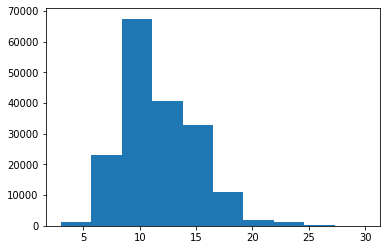

In [ ]:
# Let's Check the length of different lines
train_df.total_lines.hist(grid = False)

### Get list of Sentences

In [ ]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()
print(len(train_sen),len(val_sen),len(test_sen))

180040 30212 30135


In [ ]:
train_sen[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric Labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_oh = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_oh = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_oh = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_oh

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Integer Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/khushimitr/HandGestureRecognition/main/helperfunctions.py

from helperfunctions import calculate_results

--2022-01-15 05:00:38--  https://raw.githubusercontent.com/khushimitr/HandGestureRecognition/main/helperfunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9735 (9.5K) [text/plain]
Saving to: ‘helperfunctions.py’

helperfunctions.py  100%[===================>]   9.51K  --.-KB/s    in 0s      

2022-01-15 05:00:38 (84.6 MB/s) - ‘helperfunctions.py’ saved [9735/9735]



## Modelling Experiments

### Model 0: MultiNomial Naive Bayes TF-IDF (Baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sen, y = train_labels_encoded);

In [ ]:
## Gives Accuracy on Validation Dataset
model_0.score(X = val_sen,
                 y = val_labels_encoded)

0.7218323844829869

In [ ]:
## Make Predictions
baseline_preds = model_0.predict(val_sen)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data for deep Sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence?
sen_lens = [len(sentence.split()) for sentence in train_sen]
avg_sen_len = np.mean(sen_lens)
avg_sen_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

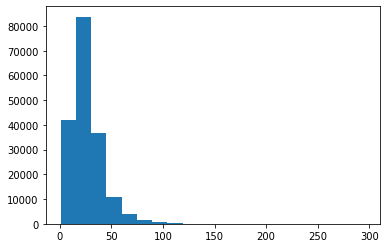

In [ ]:
# Distribution of sentences length
import matplotlib.pyplot as plt
plt.hist(sen_lens,bins = 20)

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sen_lens,95))
output_seq_len

55

In [ ]:
max(sen_lens)

296

### Text Vectorization Layer

In [ ]:
# How many words are in our vocab? (taken from table 3.2 in : https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sen)

In [ ]:
import random
target_sen = random.choice(train_sen)
print(f"Text:\n{target_sen}")
print(f"\nLength of text : {len(target_sen.split())}")
print(f"\nVectorized text : {text_vectorizer([target_sen])}")

Text:
to define the role of increased fundus autofluorescence ( faf ) , a surrogate for lipofuscin content , as a risk factor for progression of geographic atrophy ( ga ) .

Length of text : 31

Vectorized text : [[    6  4163     2   546     4    96  7875 32539 13317     8  4404    11
  37366  1014    25     8    73   432    11   499     4  5077  2788  1986
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocab
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [ ]:
print(f"Sentence before vectorization:\n{target_sen}")
vectorized_sen = text_vectorizer([target_sen])
print(f"Sentence after vectorization(before embedding):\n{vectorized_sen}")
embedded_sen = token_embed(vectorized_sen)
print(f"Sentence after embedding):\n{embedded_sen}\n")
print(f"Embedded Sentence shape : {embedded_sen.shape}")

Sentence before vectorization:
to define the role of increased fundus autofluorescence ( faf ) , a surrogate for lipofuscin content , as a risk factor for progression of geographic atrophy ( ga ) .
Sentence after vectorization(before embedding):
[[    6  4163     2   546     4    96  7875 32539 13317     8  4404    11
  37366  1014    25     8    73   432    11   499     4  5077  2788  1986
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding):
[[[-0.02597816 -0.00916777  0.04458406 ...  0.00704752  0.04806292
   -0.01462816]
  [ 0.01146737  0.00853742  0.02438922 ...  0.00303366  0.01115463
    0.02360458]
  [ 0.01566534 -0.0277872  -0.02774909 ...  0.02759269 -0.01084527
    0.02825407]
  ...
  [ 0.04116989  0.0308777  -0.01937304 ... -0.01575778 -0.00957321
   -0.04621005]
  [ 0.04116989  0.0308777  -0.01937304 ... -0.0

### Creating datasets (making sure data loads as fast as possible)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen,train_labels_oh))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen,val_labels_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen,test_labels_oh))
 
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1 : Conv1D with Token Embedding

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

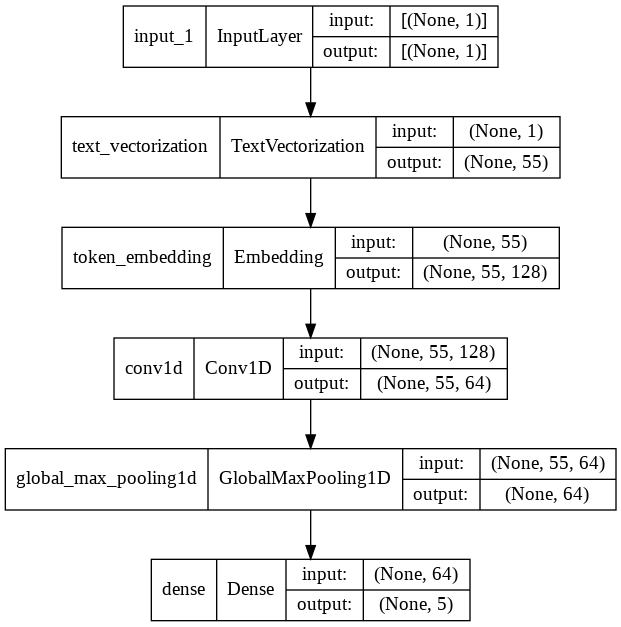

In [ ]:
tf.keras.utils.plot_model(model_1,show_shapes=True)

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=  int(0.1*len(train_dataset)),
                              epochs = 5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 15s 9ms/step - loss: 0.8394 - accuracy: 0.6784 - val_loss: 0.5873 - val_accuracy: 0.7809
Epoch 2/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5770 - accuracy: 0.7885 - val_loss: 0.5453 - val_accuracy: 0.7969
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5428 - accuracy: 0.8004 - val_loss: 0.5223 - val_accuracy: 0.8082
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5236 - accuracy: 0.8061 - val_loss: 0.5215 - val_accuracy: 0.8005
Epoch 5/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5297 - accuracy: 0.8084 - val_loss: 0.4980 - val_accuracy: 0.8112


```
WITH GlobalAveragePooling LAYER

Epoch 1/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5170 - accuracy: 0.8177 - val_loss: 0.5937 - val_accuracy: 0.7842
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.4547 - accuracy: 0.8396 - val_loss: 0.6010 - val_accuracy: 0.7806
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.4440 - accuracy: 0.8429 - val_loss: 0.6081 - val_accuracy: 0.7796
Epoch 4/5
562/562 [==============================] - 8s 13ms/step - loss: 0.5877 - accuracy: 0.7887 - val_loss: 0.5737 - val_accuracy: 0.7909
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5851 - accuracy: 0.7932 - val_loss: 0.5550 - val_accuracy: 0.7962
```

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4963 - accuracy: 0.8182


[0.49634140729904175, 0.818217933177948]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

(30212, 5)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs,axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_pred=model_1_preds,
                                    y_true = val_labels_encoded)
model_1_results

{'accuracy': 81.82179266516616,
 'f1': 0.8156148573651635,
 'precision': 0.8211767348060837,
 'recall': 0.8182179266516616}

### Model 2 : Feauture extraction with pretrained token embediings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "USE")

In [ ]:
random_train_sen = random.choice(train_sen)
print(f"Random sentence:\n {random_train_sen}")
use_embedded_sen = tf_hub_embedding_layer([random_train_sen])
print(f"Sentence after embedding :\n{use_embedded_sen[0][:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sen[0])}")

Random sentence:
 a retrospective comparison of wrinkle widths in @ climacteric women with climacteric symptoms with or without ppe treatment was also performed .
Sentence after embedding :
[-0.00452848  0.03085122  0.00075777 -0.06486815 -0.02441451 -0.02940728
  0.05391294 -0.0246392   0.07518659  0.05147455  0.06917885 -0.01977707
  0.06503987  0.0683753   0.00797309 -0.04801    -0.08618669  0.00159015
  0.02081916  0.0626694 ]

Length of sentence embedding: 512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
# print(pretrained_embedding.shape)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

(None, 512)


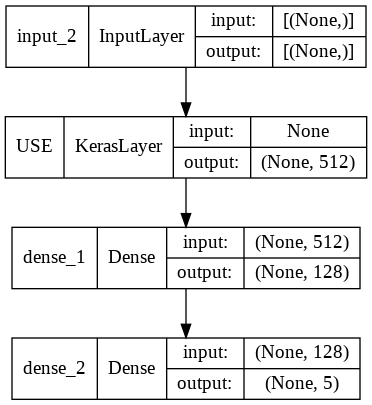

In [ ]:
tf.keras.utils.plot_model(model_2,show_shapes=True)

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 9s 13ms/step - loss: 0.9167 - accuracy: 0.6509 - val_loss: 0.7969 - val_accuracy: 0.6878
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7705 - accuracy: 0.7011 - val_loss: 0.7567 - val_accuracy: 0.7038
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7542 - accuracy: 0.7113 - val_loss: 0.7421 - val_accuracy: 0.7154
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7219 - accuracy: 0.7215 - val_loss: 0.7166 - val_accuracy: 0.7281
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7299 - accuracy: 0.7186 - val_loss: 0.6963 - val_accuracy: 0.7324


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7015 - accuracy: 0.7330


[0.7015165090560913, 0.7329537868499756]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[6.4495486e-01, 2.2649322e-01, 2.6809613e-03, 1.1458240e-01,
        1.1288596e-02],
       [4.5014319e-01, 4.6618253e-01, 5.6179226e-03, 7.4401796e-02,
        3.6544946e-03],
       [3.8908878e-01, 7.0414901e-02, 4.2423323e-02, 4.5406199e-01,
        4.4011030e-02],
       ...,
       [1.9690541e-03, 2.2388850e-03, 1.2713623e-01, 6.5838662e-04,
        8.6799741e-01],
       [2.8178124e-03, 1.9386612e-02, 4.8760509e-01, 1.0081715e-03,
        4.8918232e-01],
       [1.7816460e-01, 3.7190816e-01, 4.0081519e-01, 2.2888025e-03,
        4.6823286e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_2_preds
)
model_2_results

{'accuracy': 73.2953793194757,
 'f1': 0.7274412429536233,
 'precision': 0.7298317344154767,
 'recall': 0.7329537931947571}

### Creating a character tokenizer

In [ ]:
train_sen[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_to_chars(text):
    return " ".join(list(text))

split_to_chars(random_train_sen)

'a   r e t r o s p e c t i v e   c o m p a r i s o n   o f   w r i n k l e   w i d t h s   i n   @   c l i m a c t e r i c   w o m e n   w i t h   c l i m a c t e r i c   s y m p t o m s   w i t h   o r   w i t h o u t   p p e   t r e a t m e n t   w a s   a l s o   p e r f o r m e d   .'

In [ ]:
train_chars = [split_to_chars(sentence) for sentence in train_sen]
val_chars = [split_to_chars(sentence) for sentence in val_sen]
test_chars = [split_to_chars(sentence) for sentence in test_sen]

test_chars[:5]

['t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .',
 'a   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   e v a l u a t i o n   s t u d y   o f   c o n g e s t i v e   h e a r t   f a i l u r e   a n d   p u l m o n a r y   a r t e r y   c a t h e t e r i z a t i o n   e f f e c t i v e n e s s   (   e s c a p e   )   .',
 'l i v e r   f u n c t i o n   t e s t s   (   l f t s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
 's u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e 

In [ ]:
# Avg character length
char_lens = [len(sentence) for sentence in train_sen]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

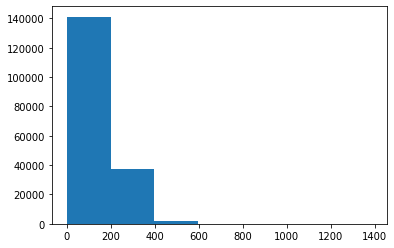

In [ ]:
# Check distribution

import matplotlib.pyplot as plt
plt.hist(char_lens,bins = 7)

In [ ]:
# What character length covers 95% of the lengths?
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet=  string.ascii_lowercase + string.digits+ string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Char level token vectorizer
num_char_tokens = len(alphabet) + 2 # for space and UNK(Unkown)
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer",
                                    # standardize = None
                                    )

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
# With no standardization

# char_vocab = char_vectorizer.get_vocabulary()
# print(f"Number of different characters in character vocab : {len(char_vocab)}")
# print(f"5 most common characters : {char_vocab[:5]}")
# print(f"5 least common characters : {char_vocab[-5:]}")

```
OUTPUT
Number of different characters in character vocab : 57
5 most common characters : ['', '[UNK]', 'e', 't', 'i']
5 least common characters : ['|', '"', ']', '\\', '[']
```

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab : {len(char_vocab)}")
print(f"5 most common characters : {char_vocab[:5]}")
print(f"5 least common characters : {char_vocab[-5:]}")

Number of different characters in character vocab : 28
5 most common characters : ['', '[UNK]', 'e', 't', 'i']
5 least common characters : ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text : \n{random_train_chars}")
print(f"\nLength of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars : \n{vectorized_chars}")
print(f"length of vectorized chars : {len(vectorized_chars[0])}")

Charified text : 
i n   t h e   p z   g r o u p   ,   t h e   m a y o   s c o r e s   a t   b a s e l i n e   a n d   a t   d a y   @   w e r e   @   @   a n d   @   @   (   p   =   @   )   ,   r e s p e c t i v e l y   ,   a n d   i n   t h e   p l a c e b o   g r o u p   ,   t h e   s c o r e s   w e r e   @   @   a n d   @   @   (   p   =   @   )   ,   r e s p e c t i v e l y   .

Length of random_train_chars : 135

Vectorized chars : 
[[ 4  6  3 13  2 14 25 18  8  7 16 14  3 13  2 15  5 19  7  9 11  7  8  2
   9  5  3 22  5  9  2 12  4  6  2  5  6 10  5  3 10  5 19 20  2  8  2  5
   6 10 14  8  2  9 14  2 11  3  4 21  2 12 19  5  6 10  4  6  3 13  2 14
  12  5 11  2 22  7 18  8  7 16 14  3 13  2  9 11  7  8  2  9 20  2  8  2
   5  6 10 14  8  2  9 14  2 11  3  4 21  2 12 19  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a charcater level embedding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25, # From paper
                              mask_zero = True,
                              name = "char_embed")

In [ ]:
print(f"Charified text : \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embediing) : \n{char_embed_example}\n")
print(f"Character Embediing shape : {char_embed_example.shape}")

Charified text : 
i n   t h e   p z   g r o u p   ,   t h e   m a y o   s c o r e s   a t   b a s e l i n e   a n d   a t   d a y   @   w e r e   @   @   a n d   @   @   (   p   =   @   )   ,   r e s p e c t i v e l y   ,   a n d   i n   t h e   p l a c e b o   g r o u p   ,   t h e   s c o r e s   w e r e   @   @   a n d   @   @   (   p   =   @   )   ,   r e s p e c t i v e l y   .

Embedded chars (after vectorization and embediing) : 
[[[-0.03406469 -0.03198983 -0.00138306 ...  0.00041193  0.03845284
   -0.02510164]
  [ 0.01345902  0.0496125   0.01838327 ...  0.03185666  0.01627156
   -0.01511753]
  [ 0.01046556 -0.00703507 -0.0156859  ... -0.02433783 -0.03830431
   -0.00049194]
  ...
  [ 0.03139368 -0.03908434 -0.03020952 ...  0.03920192 -0.04969525
    0.00528174]
  [ 0.03139368 -0.03908434 -0.03020952 ...  0.03920192 -0.04969525
    0.00528174]
  [ 0.03139368 -0.03908434 -0.03020952 ...  0.03920192 -0.04969525
    0.00528174]]]

Character Embediing shape : (1, 290, 25)


### Creating Character level datasets

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 3 : Conv1D with character embedding

In [ ]:
inputs = layers.Input(shape= (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters = 64,
                  kernel_size = 8,
                  padding = "same",
                  activation = "relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)

model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(loss= tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           12864     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

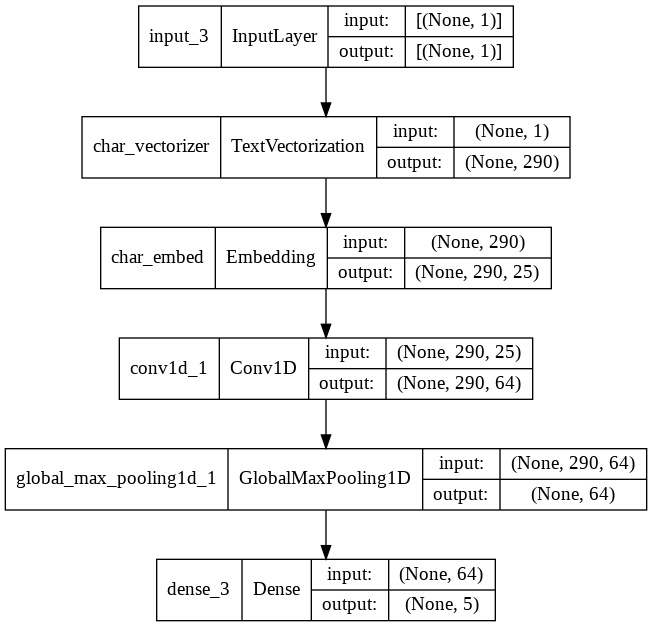

In [ ]:
tf.keras.utils.plot_model(model_3,show_shapes = True)

In [ ]:
history_model_3 = model_3.fit(
    train_char_dataset,
    epochs = 5,
    steps_per_epoch = int(0.1 * len(train_char_dataset)),
    validation_data = val_char_dataset,
    validation_steps = int(0.1 * len(val_char_dataset))
)

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2334 - accuracy: 0.5105 - val_loss: 0.9930 - val_accuracy: 0.6200
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9442 - accuracy: 0.6295 - val_loss: 0.8719 - val_accuracy: 0.6619
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8734 - accuracy: 0.6589 - val_loss: 0.8057 - val_accuracy: 0.6898
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8240 - accuracy: 0.6839 - val_loss: 0.7810 - val_accuracy: 0.6968
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8078 - accuracy: 0.6892 - val_loss: 0.7607 - val_accuracy: 0.7164


```
WITH GLOBAL AVERAGE POOLING

Epoch 1/5
562/562 [==============================] - 7s 11ms/step - loss: 1.4498 - accuracy: 0.3556 - val_loss: 1.3925 - val_accuracy: 0.4069
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 1.3590 - accuracy: 0.4260 - val_loss: 1.3273 - val_accuracy: 0.4425
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 1.3193 - accuracy: 0.4561 - val_loss: 1.3045 - val_accuracy: 0.4488
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 1.2924 - accuracy: 0.4630 - val_loss: 1.2836 - val_accuracy: 0.4678
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 1.2827 - accuracy: 0.4624 - val_loss: 1.2668 - val_accuracy: 0.4727
```

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.7819 - accuracy: 0.7027


[0.7819152474403381, 0.7027009129524231]

In [ ]:
pred_probs = model_3.predict(val_char_dataset)
pred_probs

array([[0.14211325, 0.30134118, 0.11298234, 0.41927555, 0.0242877 ],
       [0.10987905, 0.7436786 , 0.02040762, 0.08451521, 0.04151951],
       [0.15524554, 0.43772548, 0.12592025, 0.2493606 , 0.0317481 ],
       ...,
       [0.00725105, 0.03245408, 0.05517396, 0.0076817 , 0.89743924],
       [0.02841543, 0.19570698, 0.39767227, 0.04268895, 0.33551636],
       [0.15698947, 0.7917871 , 0.02957133, 0.01753923, 0.00411291]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(pred_probs,axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 2, 1])>

In [ ]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_3_preds)
model_3_results

{'accuracy': 70.2700913544287,
 'f1': 0.6972802224171812,
 'precision': 0.7029668840999075,
 'recall': 0.702700913544287}

### Model 4 : MultiModal (Combining pretrained token embediings + characters embediings)

In [ ]:
# 1. Setup token input/model
token_inputs = layers.Input(shape = (1,), dtype = tf.string,name = "token_input")
# token_embeddings = tf_hub_embedding_layer(token_inputs)
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
x = layers.GlobalMaxPool1D()(token_embeddings)
# print(x.shape)
token_output = layers.Dense(128,activation ="relu")(x)
# print(token_output.shape)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [ ]:
# 2. Setup char input/model
char_inputs = layers.Input(shape = (1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs,char_bi_lstm)

In [ ]:
# 3. Concatenate token and char inputs (hybrid token embeddings)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

In [ ]:
# 4. Create output layers - adding in DropOut
combined_dropout = layers.Dropout(0.4)(token_char_concat)
combined_dense = layers.Dense(128,activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.2)(combined_dense)
output_layer = layers.Dense(num_classes,activation = "softmax")(final_dropout)

In [ ]:
# 5. Constrict model
model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],
                         outputs = output_layer,
                         name = "model_4"
                         )

In [ ]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      8299648     ['text_vectorization[9][0]'

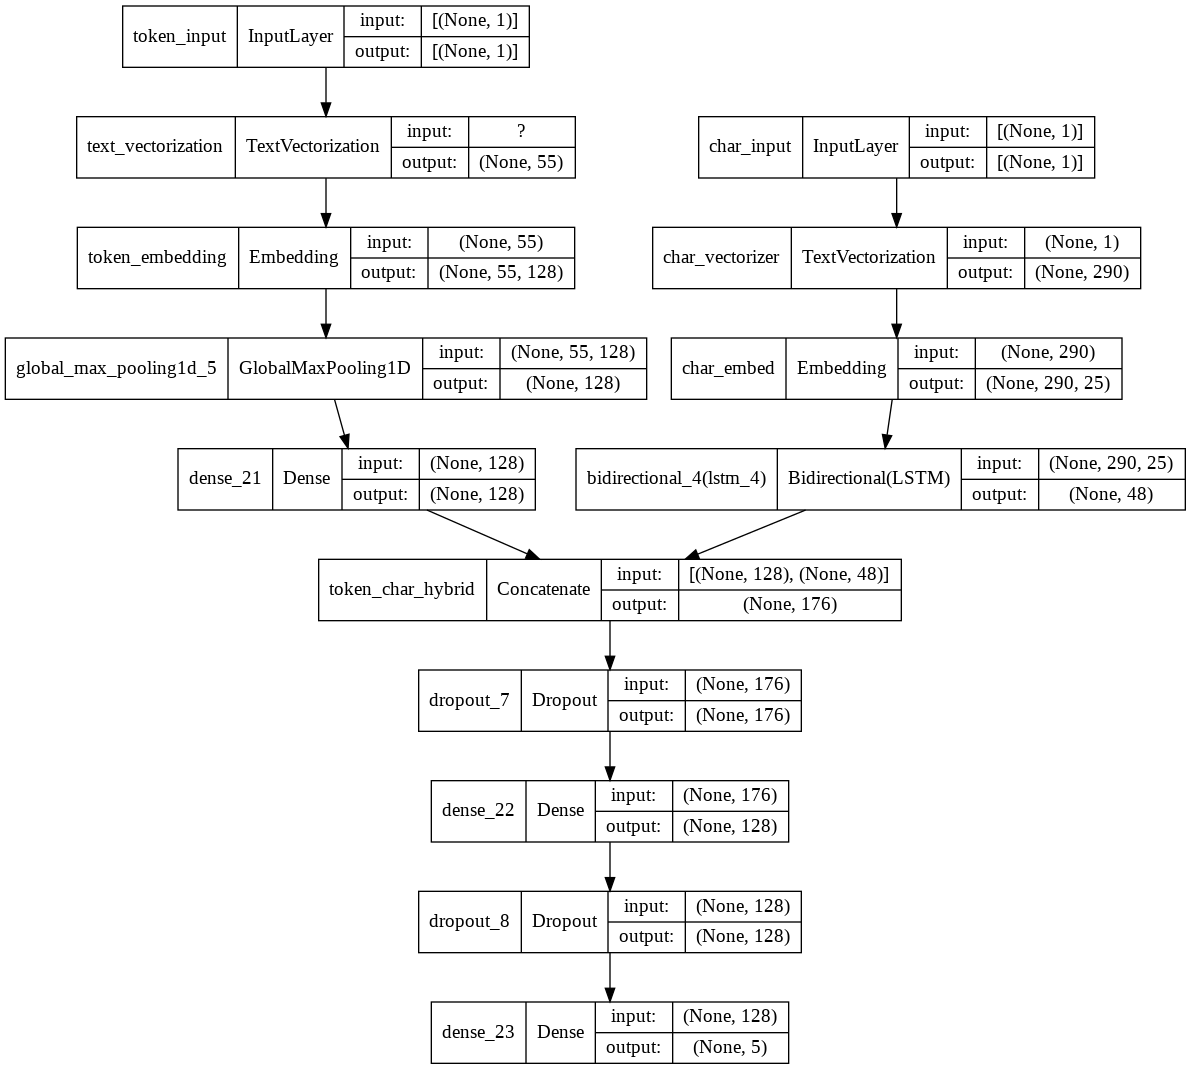

In [ ]:
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

#### Creating performant datasets pipeline

In [ ]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sen,train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

len(train_token_char_dataset)

5627

In [ ]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sen,val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

len(val_token_char_dataset)

945

In [ ]:
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sen,test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))

test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

len(test_token_char_dataset)

942

### 

In [ ]:
history_model_4 = model_4.fit(
    train_token_char_dataset,
    epochs = 5,
    steps_per_epoch = int(0.1 * len(train_token_char_dataset)),
    validation_data = val_token_char_dataset,
    validation_steps = int(0.1 * len(val_token_char_dataset))
)

Epoch 1/5
562/562 [==============================] - 34s 48ms/step - loss: 0.6414 - accuracy: 0.7664 - val_loss: 0.5311 - val_accuracy: 0.8065
Epoch 2/5
562/562 [==============================] - 24s 43ms/step - loss: 0.4669 - accuracy: 0.8317 - val_loss: 0.5446 - val_accuracy: 0.7989
Epoch 3/5
562/562 [==============================] - 21s 38ms/step - loss: 0.4424 - accuracy: 0.8429 - val_loss: 0.5340 - val_accuracy: 0.7989
Epoch 4/5
562/562 [==============================] - 25s 44ms/step - loss: 0.4247 - accuracy: 0.8489 - val_loss: 0.5376 - val_accuracy: 0.7949
Epoch 5/5
562/562 [==============================] - 23s 40ms/step - loss: 0.4272 - accuracy: 0.8506 - val_loss: 0.5409 - val_accuracy: 0.7985


```
USING TENSORFLOW HUB PRETRAINED UNIVERSAL SENTENCE ENCODER FOR TOKEN EMBEDDINGS

Epoch 1/5
562/562 [==============================] - 37s 51ms/step - loss: 0.9237 - accuracy: 0.6379 - val_loss: 0.7545 - val_accuracy: 0.7081
Epoch 2/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7524 - accuracy: 0.7078 - val_loss: 0.6931 - val_accuracy: 0.7397
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 0.7301 - accuracy: 0.7191 - val_loss: 0.6637 - val_accuracy: 0.7520
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7006 - accuracy: 0.7333 - val_loss: 0.6477 - val_accuracy: 0.7530
Epoch 5/5
562/562 [==============================] - 25s 45ms/step - loss: 0.7050 - accuracy: 0.7316 - val_loss: 0.6365 - val_accuracy: 0.7560
```

In [ ]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.5349 - accuracy: 0.8074


[0.5348564386367798, 0.8073943853378296]

In [ ]:
pred_probs = model_4.predict(val_token_char_dataset)
pred_probs

array([[6.7839360e-01, 7.2858751e-02, 1.6558064e-02, 2.2850084e-01,
        3.6887662e-03],
       [6.5541267e-01, 1.1709811e-01, 9.3731806e-03, 2.1546195e-01,
        2.6540922e-03],
       [3.6195987e-01, 6.3007381e-03, 9.4430214e-03, 6.2193233e-01,
        3.6410516e-04],
       ...,
       [8.8009710e-06, 1.9502184e-04, 4.8990464e-03, 2.0046032e-06,
        9.9489504e-01],
       [8.2942642e-02, 4.0799865e-01, 2.1217722e-01, 4.8791010e-02,
        2.4809052e-01],
       [9.6918372e-03, 9.7507781e-01, 1.8180707e-03, 5.6335464e-04,
        1.2848988e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(pred_probs,axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_4_preds)
model_4_results

{'accuracy': 80.73944128160996,
 'f1': 0.804701806488177,
 'precision': 0.8110884819036299,
 'recall': 0.8073944128160996}

**Feature Engineering**
```
Taking non obvious features from the data and encoding them numerically to help our model learn.
In our scenario we know that Objective will be at the start of the paragraph followed by methods then results and finally Conclusion.

Engineered features need to be available at test time. In our case line numbers and total lines are available.
```


In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create Positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

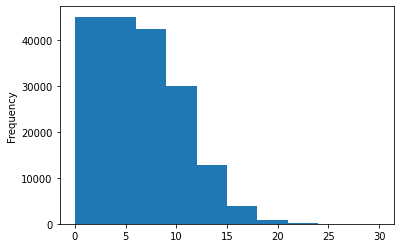

In [ ]:
# Check the distribution of column
train_df.line_number.plot.hist()

In [ ]:
# Use tensorflow to create one-hot-encode labels for line_number
# NOTE : --- Not using integers to remove the mathematical relation between numbers because they don't hold significance

train_line_no_oh = tf.one_hot(train_df["line_number"].to_numpy(),depth= 15)
val_line_no_oh = tf.one_hot(val_df["line_number"].to_numpy(),depth= 15)
test_line_no_oh = tf.one_hot(test_df["line_number"].to_numpy(),depth= 15)
train_line_no_oh[:10],train_line_no_oh.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
# How many different total line values are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

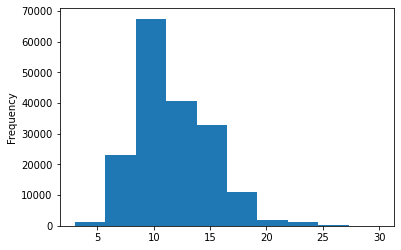

In [ ]:
# Check the distribution
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines,95), np.percentile(train_df.total_lines,98)

(18.0, 20.0)

In [ ]:
train_total_lines_no_oh = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_no_oh = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_no_oh = tf.one_hot(test_df["total_lines"].to_numpy(),depth= 20)
train_total_lines_no_oh[:10],train_total_lines_no_oh.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Creating the appropriate datasets for model 5

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_no_oh,train_total_lines_no_oh,train_sen,train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_no_oh,val_total_lines_no_oh,val_sen,val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_no_oh,test_total_lines_no_oh,test_sen,test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

### Model 5 : Transfer learning with pretrained token embediings + character embeddings + positional embediings

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype = tf.string,name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(256,activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [ ]:
# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype = tf.string,name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [ ]:
# 3. Line Number Model
line_no_inputs = layers.Input(shape=(15,),dtype = tf.float32,name="line_no_inputs")
x = layers.Dense(32,activation="relu")(line_no_inputs)
line_no_model = tf.keras.Model(inputs = line_no_inputs,
                               outputs = x)

In [ ]:
# 4. Total Line Number Model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                      outputs = y)

In [ ]:
# 5. Combine 1 and 2 into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

In [ ]:
# 6. 
z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [ ]:
# 7. Combine positional embediing with 5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_no_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

In [ ]:
# 8. Create output layer
output_layer = layers.Dense(num_classes,activation="softmax",name = "output_layer")(tribrid_embeddings)

In [ ]:
# 9. Put together model with all kinds of inputs
model_5 = tf.keras.Model(
    inputs=[
            line_no_model.input,
            total_lines_model.input,
            token_model.input,
            char_model.input
    ],
    outputs=output_layer,
    name = "tribrid_embedding_model"
)

In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inp

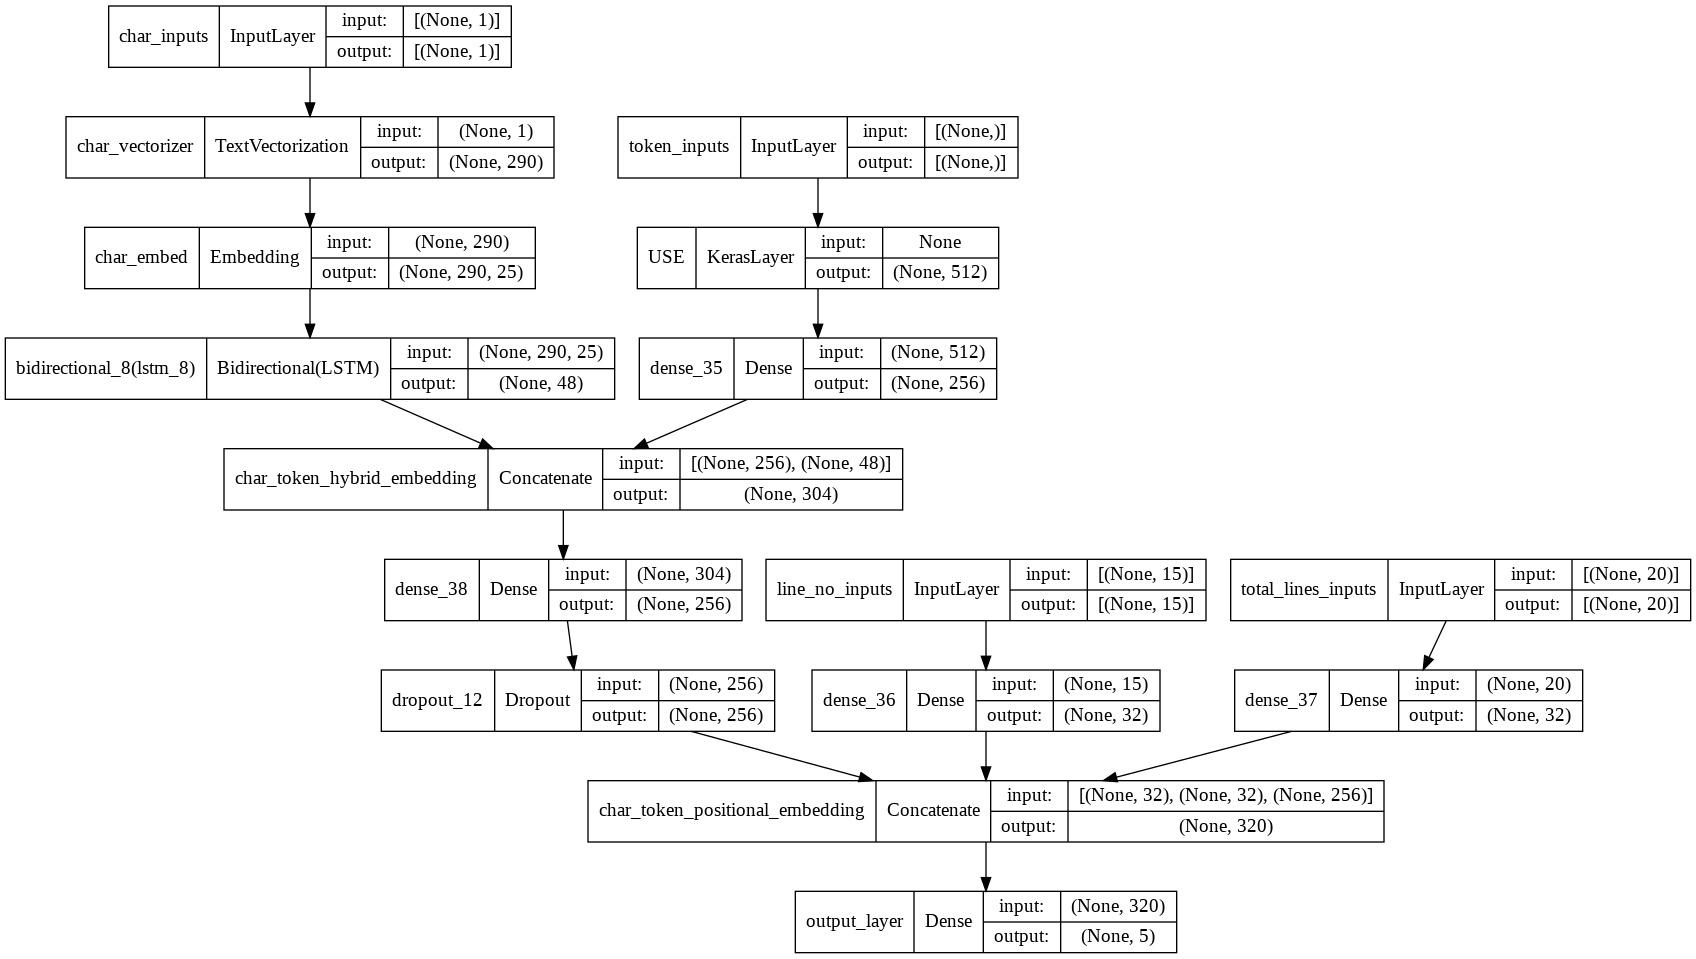

In [ ]:
tf.keras.utils.plot_model(model_5,show_shapes = True)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_model_5 = model_5.fit(
    train_char_token_pos_dataset,
    epochs = 5,
    steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
    validation_data = val_char_token_pos_dataset,
    validation_steps = int(0.1 * len(val_char_token_pos_dataset))
)

Epoch 1/5
562/562 [==============================] - 39s 54ms/step - loss: 1.0842 - accuracy: 0.7320 - val_loss: 0.9724 - val_accuracy: 0.8105
Epoch 2/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9617 - accuracy: 0.8212 - val_loss: 0.9422 - val_accuracy: 0.8301
Epoch 3/5
562/562 [==============================] - 25s 45ms/step - loss: 0.9447 - accuracy: 0.8284 - val_loss: 0.9356 - val_accuracy: 0.8361
Epoch 4/5
562/562 [==============================] - 30s 53ms/step - loss: 0.9354 - accuracy: 0.8374 - val_loss: 0.9247 - val_accuracy: 0.8374
Epoch 5/5
562/562 [==============================] - 27s 48ms/step - loss: 0.9324 - accuracy: 0.8394 - val_loss: 0.9183 - val_accuracy: 0.8454


```
USING OUR OWN CUSTOM TOKEN EMBEDDINGS

Epoch 1/5
562/562 [==============================] - 37s 50ms/step - loss: 0.9144 - accuracy: 0.8613 - val_loss: 0.9254 - val_accuracy: 0.8344
Epoch 2/5
562/562 [==============================] - 25s 45ms/step - loss: 0.8224 - accuracy: 0.9202 - val_loss: 0.9171 - val_accuracy: 0.8451
Epoch 3/5
562/562 [==============================] - 22s 39ms/step - loss: 0.8015 - accuracy: 0.9311 - val_loss: 0.9403 - val_accuracy: 0.8158
Epoch 4/5
562/562 [==============================] - 26s 45ms/step - loss: 0.7935 - accuracy: 0.9347 - val_loss: 0.9160 - val_accuracy: 0.8351
Epoch 5/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7907 - accuracy: 0.9356 - val_loss: 0.9187 - val_accuracy: 0.8374

```

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.9172 - accuracy: 0.8441


[0.9172335267066956, 0.8441016674041748]

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,verbose = 1)
model_5_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[0.58122826, 0.07391197, 0.02266145, 0.2929671 , 0.02923129],
       [0.601137  , 0.09401171, 0.067307  , 0.22269967, 0.01484462],
       [0.33455658, 0.09898743, 0.13228199, 0.39014322, 0.04403077],
       ...,
       [0.02820366, 0.051066  , 0.02992649, 0.02522955, 0.8655743 ],
       [0.0257724 , 0.27701637, 0.14838922, 0.02681235, 0.5220097 ],
       [0.06496485, 0.76524717, 0.07594605, 0.01968918, 0.07415277]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs,axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_5_preds)
model_5_results

{'accuracy': 84.4101681451079,
 'f1': 0.8407222197032845,
 'precision': 0.8460548820236207,
 'recall': 0.844101681451079}

In [ ]:
model_4_results

{'accuracy': 80.73944128160996,
 'f1': 0.804701806488177,
 'precision': 0.8110884819036299,
 'recall': 0.8073944128160996}

## Compare model results

In [ ]:
model_results = pd.DataFrame(
    {
        "model_0_baseline": baseline_results,
        "model_1_custom_token_embed_conv1d": model_1_results,
        "model_2_pretrained_token_embed": model_2_results,
        "model_3_custom_char_embed_conv1d": model_3_results,
        "model_4_hybrid_char_token_embed": model_4_results,
        "model_5_tribrid_pos_char_token_embed": model_5_results
    }
)

model_results = model_results.transpose()
model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embed_conv1d,81.821793,0.821177,0.818218,0.815615
model_2_pretrained_token_embed,73.295379,0.729832,0.732954,0.727441
model_3_custom_char_embed_conv1d,70.270091,0.702967,0.702701,0.697280
model_4_hybrid_char_token_embed,80.739441,0.811088,0.807394,0.804702
model_5_tribrid_pos_char_token_embed,84.410168,0.846055,0.844102,0.840722


In [ ]:
model_results["accuracy"] = model_results["accuracy"]/100

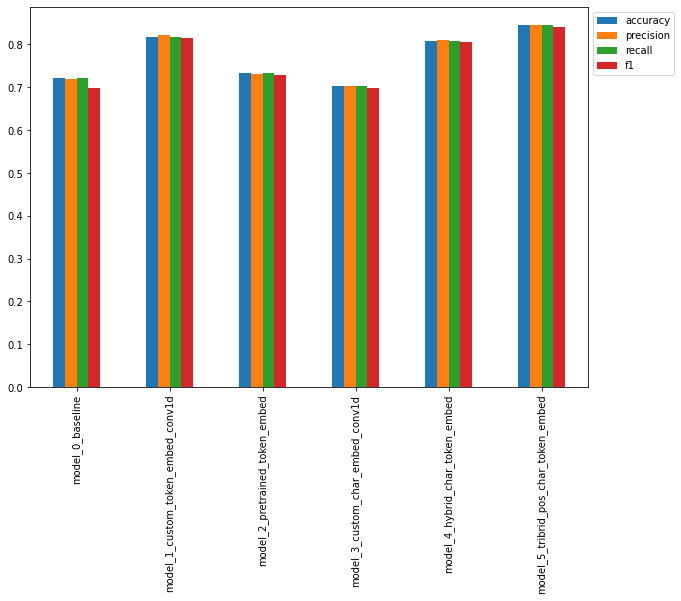

In [ ]:
model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

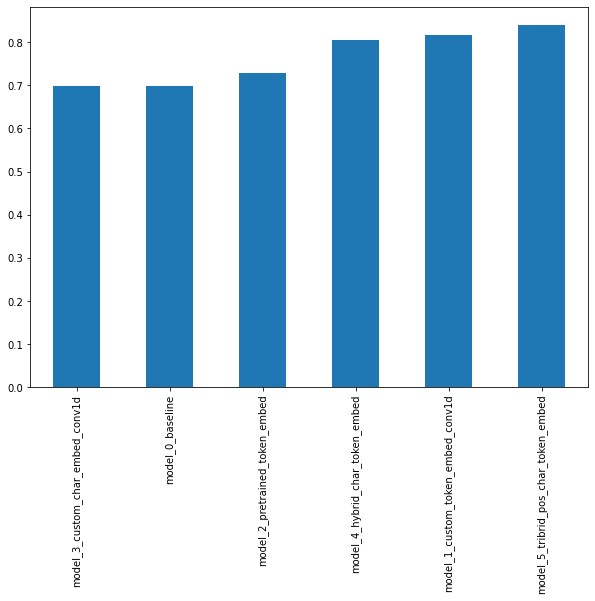

In [ ]:
model_results.sort_values("f1",ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

## Evaluate model on test data

In [ ]:
test_pred_probs = model_5.predict(test_char_token_pos_dataset,verbose = 1)
test_preds = tf.argmax(test_pred_probs,axis = 1)
test_preds

942/942 [==============================] - 22s 23ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
test_results = calculate_results(y_true = test_labels_encoded,
                                 y_pred = test_preds)
test_results

{'accuracy': 83.91903102704497,
 'f1': 0.8358108015393508,
 'precision': 0.8403030205442932,
 'recall': 0.8391903102704497}

## Find Most Wrong predictions

In [ ]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
print(test_pred_classes)

['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'METHODS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'METHODS', 'BACKGROUND', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'RESULTS', 'OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND'

In [ ]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.405244,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.438730,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.826329,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.861542,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.709512,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.843218,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.528815,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.520669,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.492643,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.603103,True


In [ ]:
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.954431,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.952670,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.944886,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.939520,False
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,15,BACKGROUND,0.933759,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.929593,False
5330,OBJECTIVE,@ .,5,15,METHODS,0.927173,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.926102,False
15316,BACKGROUND,@ .,4,15,METHODS,0.925576,False
12459,RESULTS,adherence to follow-up was measured .,4,13,METHODS,0.923383,False


## Make example Predictions

```
abstract from `RCT of a manualized social treatment for high-functioning autism spectrum disorders` : https://pubmed.ncbi.nlm.nih.gov/20232240/
```

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2022-01-15 07:39:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-01-15 07:39:51 (98.8 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
import json
with open("/content/skimlit_example_abstracts.json","r") as f:
    example_abstract = json.load(f)
example_abstract

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [ ]:
abstracts = pd.DataFrame(example_abstract)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstract[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
abstract_chars = [split_to_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.36479935, 0.10760216, 0.02495414, 0.4524624 , 0.05018198],
       [0.06714676, 0.02746101, 0.77929443, 0.07597288, 0.05012491],
       [0.12938339, 0.04600086, 0.6708356 , 0.09844463, 0.05533552],
       [0.08009561, 0.1283577 , 0.6151949 , 0.05751074, 0.11884101],
       [0.04577198, 0.08155549, 0.43183082, 0.04386295, 0.39697874],
       [0.03856311, 0.08051968, 0.61832994, 0.04061053, 0.22197679],
       [0.02818038, 0.16129717, 0.06350838, 0.02595664, 0.7210575 ],
       [0.01793305, 0.12453514, 0.21371163, 0.02891457, 0.61490566]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
